In [28]:
import os
import datetime
import inspect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import scatterplotmatrix
from sklearn.model_selection import (
    train_test_split, learning_curve, GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
)
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor
)
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, RANSACRegressor, 
    Lasso, Ridge, ElasticNet
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, precision_recall_curve, 
    f1_score, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor

from utils import describe_dataframe, get_cont_enrolled, train_eval, piped_traineval, df_train_test



In [29]:
main = pd.read_csv("../data/combo_data.csv")
main

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,...,NUM_DIAG,ICD_Description,DRG_TITLE,STATE_CODE,COUNTY_CD,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,-10000010254618,-10000930037831,2015-03-25,2015-03-25,2015,0,551,S134XX,1,1,...,9,Sprain of ligaments of cervical spine,MEDICAL BACK PROBLEMS WITH MCC,1,1500,1,1,0,16,275.19
1,-10000010254653,-10000930038030,2015-09-24,2015-09-24,2015,0,951,Z3480,1,1,...,4,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1400,2,1,0,33,0.00
2,-10000010254653,-10000930038031,2017-05-09,2017-05-10,2017,1,923,T7432X,1,3,...,3,"Child psychological abuse, confirmed","OTHER INJURY, POISONING AND TOXIC EFFECT DIAGN...",1,1400,2,1,0,35,0.00
3,-10000010254656,-10000930038162,2017-01-14,2017-01-14,2017,0,564,S8290X,1,1,...,4,Unspecified fracture of unspecified lower leg,OTHER MUSCULOSKELETAL SYSTEM AND CONNECTIVE TI...,1,1360,2,1,0,18,302.04
4,-10000010254656,-10000930038163,2018-03-17,2018-03-17,2018,0,951,Z3480,1,1,...,6,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1360,2,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010288008,-10000931485965,2020-01-08,2020-01-14,2020,6,0,T50901A,1,3,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20863,-10000010288008,-10000931485967,2020-10-23,2020-10-23,2020,0,0,T50901A,1,1,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20864,-10000010288008,-10000931485969,2021-08-22,2021-08-23,2021,1,0,T50901A,1,1,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
20865,-10000010288008,-10000931485971,2021-09-13,2021-09-16,2021,3,0,T50901A,1,2,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00


In [30]:
select_cols = ["LOS" ,"YR",  "PRNCPAL_DGNS_CD", "CLM_IP_ADMSN_TYPE_CD", "ER_flag", "STATE_CODE", "COUNTY_CD", "BENE_RACE_CD", "ESRD_IND","Age", "TOT_RX_CST_AMT"]

In [31]:
main.columns
workingdf = main[select_cols]

describe_dataframe(workingdf)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]",0,104,1.054919
1,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]",2015,2023,2019.100014
2,PRNCPAL_DGNS_CD,object,20867,0,190,"[S134XX, Z3480, T7432X, S8290X, Z3400]",None,None,None
3,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]",1,3,1.399195
4,ER_flag,int64,20867,0,2,"[0, 1]",0,1,0.048498
5,STATE_CODE,int64,20867,0,51,"[1, 2, 3, 4, 6]",1,53,24.974553
6,COUNTY_CD,int64,20867,0,1350,"[1500, 1400, 1360, 1440, 1120]",1010,53220,25327.166339
7,BENE_RACE_CD,int64,20867,0,6,"[1, 4, 2, 5, 3]",1,6,2.049456
8,ESRD_IND,object,20867,0,2,"[0, Y]",None,None,None
9,Age,int64,20867,0,112,"[16, 33, 35, 18, 19]",0,111,66.288015


In [32]:
len(main[main["LOS"] > 10].loc[:,"ICD_Description"].unique())
#36 ICD codes with LOS > 10

36

In [33]:
#Note: All ICD Descriptions are based off of the principal diagnosis code
workingdf.head(10)
workingdf.loc[:, workingdf.columns != "PRNCPAL_DGNS_CD"]

,LOS,YR,CLM_IP_ADMSN_TYPE_CD,ER_flag,STATE_CODE,COUNTY_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,0,2015,1,0,1,1500,1,0,16,275.19
1,0,2015,1,0,1,1400,1,0,33,0.00
2,1,2017,3,0,1,1400,1,0,35,0.00
3,0,2017,1,0,1,1360,1,0,18,302.04
4,0,2018,1,0,1,1360,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...
20862,6,2020,3,0,5,5430,5,0,75,0.00
20863,0,2020,1,0,5,5430,5,0,75,0.00
20864,1,2021,1,1,5,5430,5,0,76,0.00
20865,3,2021,2,0,5,5430,5,0,76,0.00


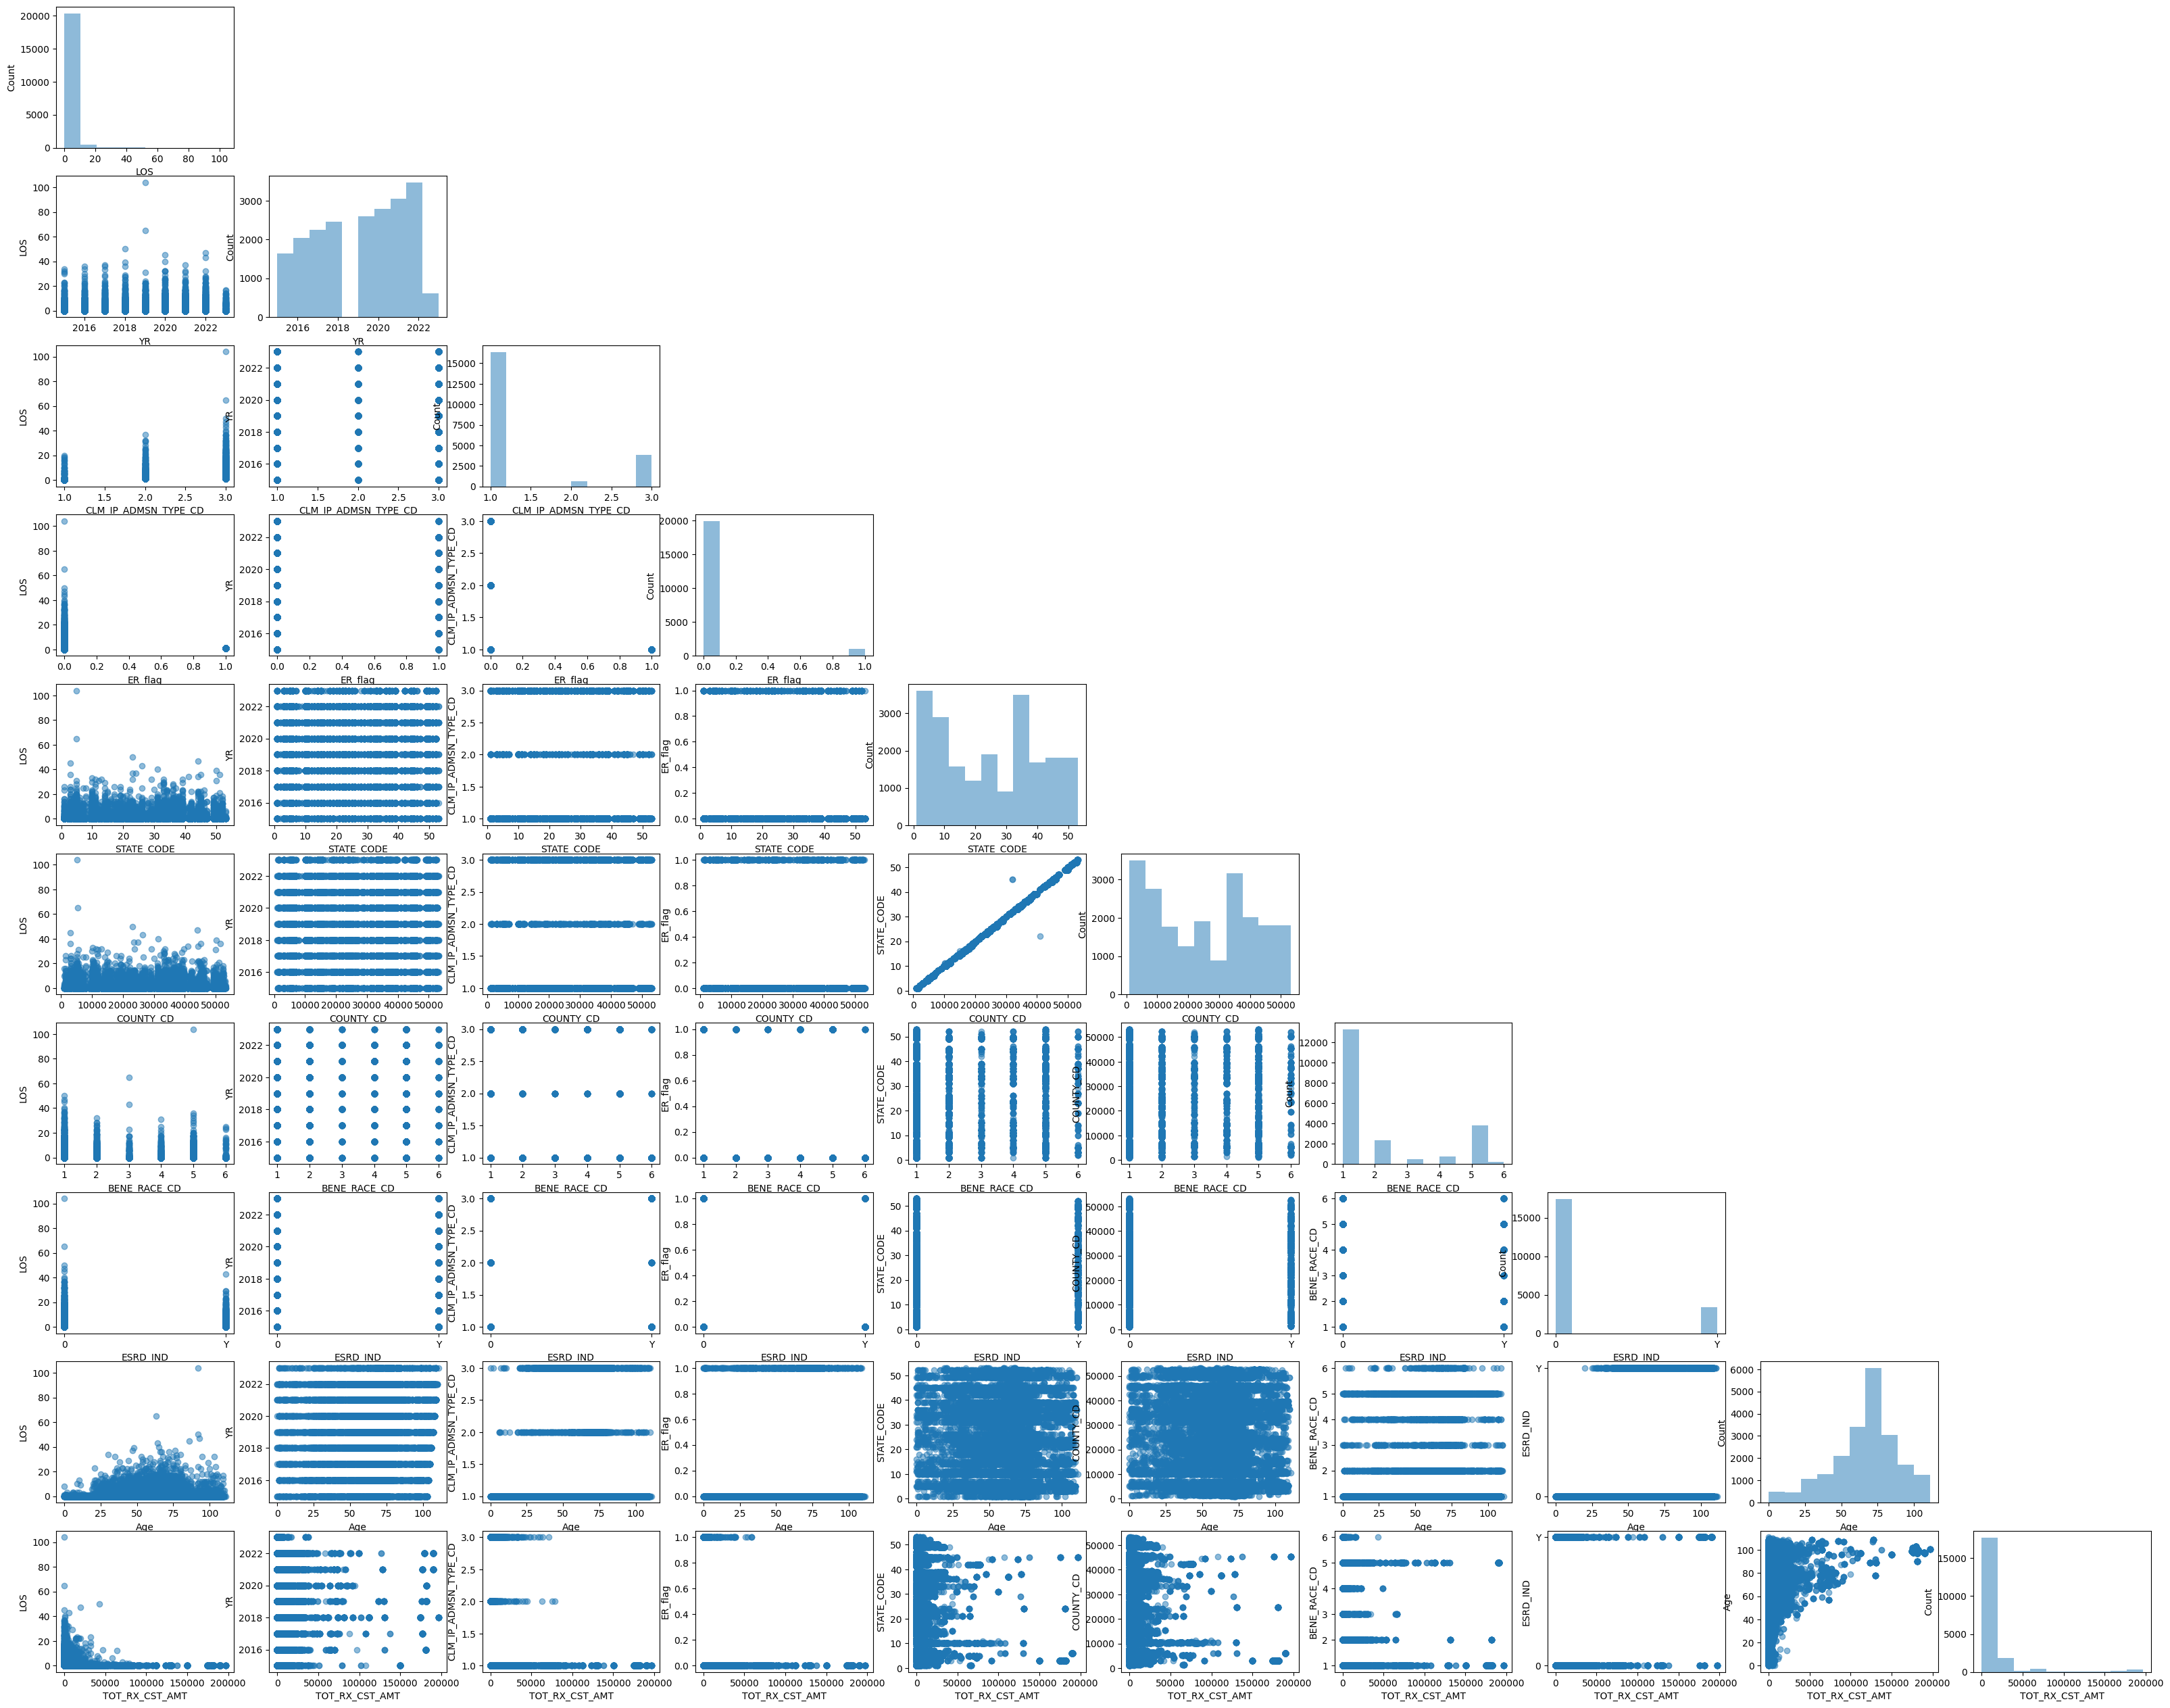

In [34]:
scatterplotmatrix(workingdf.loc[:, workingdf.columns != "PRNCPAL_DGNS_CD"].values, figsize=(40,32), names = workingdf.loc[:, workingdf.columns != "PRNCPAL_DGNS_CD"].columns, alpha=0.5)
plt.show()

In [35]:
severe_codes = workingdf.loc[workingdf["LOS"] > 10, "PRNCPAL_DGNS_CD"].unique()
workingdf = workingdf.assign(SEV_FLAG=np.where(workingdf["PRNCPAL_DGNS_CD"].isin(severe_codes), 1, 0))
#Have to use severity flag (which could be determined in many ways) instead of PRCNPAL_DGNS_CD because PRNCP can't be used with regression
workingdf = workingdf.assign(ESRD_IND = workingdf["ESRD_IND"].map({"Y": 1, "0" : 0}))

In [36]:
workingdf = workingdf.drop(columns=["PRNCPAL_DGNS_CD"])
workingdf

,LOS,YR,CLM_IP_ADMSN_TYPE_CD,ER_flag,STATE_CODE,COUNTY_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT,SEV_FLAG
0,0,2015,1,0,1,1500,1,0,16,275.19,0
1,0,2015,1,0,1,1400,1,0,33,0.00,0
2,1,2017,3,0,1,1400,1,0,35,0.00,1
3,0,2017,1,0,1,1360,1,0,18,302.04,0
4,0,2018,1,0,1,1360,1,0,19,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
20862,6,2020,3,0,5,5430,5,0,75,0.00,1
20863,0,2020,1,0,5,5430,5,0,75,0.00,1
20864,1,2021,1,1,5,5430,5,0,76,0.00,1
20865,3,2021,2,0,5,5430,5,0,76,0.00,1


In [37]:
#Need to divide up the data into training and testing sets by year
wdf_2016 = workingdf[workingdf["YR"] == 2016]
wdf_2017 = workingdf[workingdf["YR"] == 2017]


In [38]:
X_train_2016, X_test_2016, y_train_2016, y_test_2016 = df_train_test(workingdf, "LOS", 0.2)

X_train_2017, X_test_2017, y_train_2017, y_test_2017 = df_train_test(workingdf, "LOS", 0.2)

In [39]:
describe_dataframe(X_train_2016)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,YR,int64,16693,0,9,"[2023, 2021, 2017, 2019, 2022]",2015.0,2023.00,2019.101959
1,CLM_IP_ADMSN_TYPE_CD,int64,16693,0,3,"[1, 3, 2]",1.0,3.00,1.396394
2,ER_flag,int64,16693,0,2,"[0, 1]",0.0,1.00,0.049961
3,STATE_CODE,int64,16693,0,51,"[10, 49, 15, 19, 45]",1.0,53.00,24.995687
4,COUNTY_CD,int64,16693,0,1289,"[10280, 49060, 15130, 19360, 45410]",1010.0,53220.00,25346.713892
5,BENE_RACE_CD,int64,16693,0,6,"[5, 1, 2, 3, 4]",1.0,6.00,2.046966
6,ESRD_IND,int64,16693,0,2,"[0, 1]",0.0,1.00,0.164260
7,Age,int64,16693,0,112,"[74, 26, 67, 44, 55]",0.0,111.00,66.256575
8,TOT_RX_CST_AMT,float64,16693,0,6195,"[0.0, 2976.62, 2314.35, 535.9000000000001, 151...",0.0,197011.98,11478.737749
9,SEV_FLAG,int64,16693,0,2,"[1, 0]",0.0,1.00,0.516085


In [40]:
slr = LinearRegression()

#Model evaluated using same year data

slr.fit(X_train_2016, y_train_2016)
y_train_pred = slr.predict(X_train_2016)
y_test_pred = slr.predict(X_test_2016)

In [41]:
len(y_train_pred)

16693

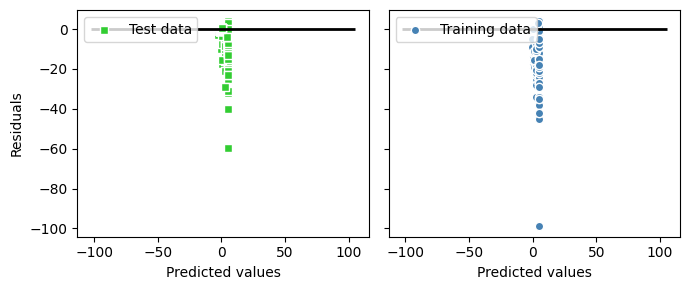

In [42]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(
    y_test_pred,
    y_test_pred - y_test_2016,
    c="limegreen",
    marker="s",
    edgecolor="white",
    label="Test data",
)
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train_2016,
    c="steelblue",
    marker="o",
    edgecolor="white",
    label="Training data",
)
ax1.set_ylabel("Residuals")

for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc="upper left")
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color="black", lw=2)

plt.tight_layout()

plt.show()